# Joe Garcia
# 12/16/25
# Data 620 Web Analytics

# Import Libraries and Load the MovieLens 100K Dataset
This section sets up the notebook by importing the main libraries needed for data handling (pandas, numpy), network analysis (NetworkX), and plotting (matplotlib). It then downloads the MovieLens 100K dataset if it is not already saved locally, unzips it, and loads two key files: the ratings table (user–movie ratings) and the movie metadata table (titles and genres). Finally, it assigns each movie a single “main genre” by selecting the genre column marked as 1, and prints the shapes of the two dataframes so we can confirm the data loaded correctly before building the network.

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from zipfile import ZipFile
import urllib.request
from pathlib import Path

Imported our data.

In [10]:
data_dir = Path("ml-100k")
zip_path = Path("ml-100k.zip")

# MovieLens Data Download and Loading
This section checks whether the MovieLens 100K dataset is already available locally. If the dataset folder is missing, the code downloads the zipped files directly from GroupLens, extracts them, and then loads the two core tables into pandas: ratings (user–movie ratings with timestamps) and movies (movie metadata and genre indicator columns). After assigning clear column names, it derives a single main genre label for each movie by selecting the genre column with the strongest indicator, and finally prints the dimensions of both datasets to confirm they loaded correctly.

In [11]:
# If the dataset folder doesn't exist locally, download and extract it
if not data_dir.exists():
    # If the zip file also isn't present, download MovieLens 100K from GroupLens
    if not zip_path.exists():
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        urllib.request.urlretrieve(url, zip_path)

    # Extract the downloaded zip into the current directory
    with ZipFile(zip_path, "r") as z:
        z.extractall(".")

# Load the ratings file:
# - tab-separated values
# - columns: user_id, movie_id, rating, timestamp
ratings = pd.read_csv(
    data_dir / "u.data",
    sep="\t",
    names=["user_id", "movie_id", "rating", "timestamp"]
)

# Load the movie metadata file:
# - pipe-separated values
# - latin-1 encoding avoids errors due to special characters in titles
# - no header row in the raw file, so header=None
movies = pd.read_csv(
    data_dir / "u.item",
    sep="|",
    encoding="latin-1",
    header=None
)

# Define column names for the movie file:
# first basic movie info columns, then 19 genre indicator columns (0/1)
movie_cols = ["movie_id", "title", "release_date", "video_release_date", "imdb_url"]
genre_cols = [
    "unknown","Action","Adventure","Animation","Children","Comedy","Crime","Documentary",
    "Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller",
    "War","Western"
]

# Assign the full set of column names to the movies DataFrame
movies.columns = movie_cols + genre_cols

# Create a single "genre" label by taking the genre column with the highest value
# (in MovieLens 100K these are typically binary flags, so this picks the first 1 it finds)
movies["genre"] = movies[genre_cols].idxmax(axis=1)

# Sanity check: print shapes of the loaded datasets (rows, columns)
ratings.shape, movies.shape


((100000, 4), (1682, 25))

# Build the Bipartite User–Movie Network
This code creates a bipartite network where there are two distinct types of nodes: users and movies. Each user node is labeled with a “U” prefix (for example, U15) and each movie node is labeled with an “M” prefix (for example, M50) so the two groups stay clearly separated. An edge is added between a user and a movie whenever that user rated that movie, and the rating value is stored as the edge weight. At the end, the code prints the total number of nodes and edges, which gives a quick check that the network was built correctly and shows how large the rating network is.

In [12]:
# Create an empty graph that will represent a bipartite network (users ↔ movies)
B = nx.Graph()

# Build node labels for the two node types:
# prefix users with "U" so they never collide with movie IDs
# prefix movies with "M" for the same reason
user_nodes = [f"U{u}" for u in ratings["user_id"].unique()]
movie_nodes = [f"M{m}" for m in ratings["movie_id"].unique()]

# Add user nodes and tag them as the "users" bipartite set
B.add_nodes_from(user_nodes, bipartite="users")

# Add movie nodes and tag them as the "movies" bipartite set
B.add_nodes_from(movie_nodes, bipartite="movies")

# Add edges from each user to each movie they rated
# The edge weight stores the numeric rating (e.g., 1–5)
for u, m, r in ratings[["user_id", "movie_id", "rating"]].itertuples(index=False):
    B.add_edge(f"U{u}", f"M{m}", weight=float(r))

# Quick check: total nodes (users + movies) and total rating edges
B.number_of_nodes(), B.number_of_edges()



(2625, 100000)

# Movie/Movie Projection and “Islands” of Shared Audiences
This section converts the original bipartite user/movie ratings network into a movie/movie network by projecting the graph onto the movie nodes. In this projected graph, two movies are connected if they were rated by the same users, and the edge weight represents how many users the two movies share. To focus on the strongest relationships and avoid a cluttered network, the code filters out weak connections by keeping only movie pairs with at least a chosen number of shared users. Finally, it identifies the connected components (or “islands”) in the filtered graph, which represent clusters of movies that are linked through overlapping audiences.

In [13]:
from networkx.algorithms import bipartite

# Separate the two node sets from the bipartite graph B using the stored node attribute
users = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "users"]
movies_nodes = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "movies"]

# Project the bipartite user–movie graph onto the MOVIE side:
# Nodes become movies
# An edge connects two movies if they share users
# Edge "weight" = number of shared users who rated both movies
Mproj = bipartite.weighted_projected_graph(B, movies_nodes)

# Keep only strong movie–movie connections to reduce noise:
# minimum number of shared users required to keep an edge
min_shared_users = 25
edges_keep = [
    (u, v, d)
    for u, v, d in Mproj.edges(data=True)
    if d.get("weight", 0) >= min_shared_users
]

# Build a filtered graph containing only the kept edges (and their weights)
G_islands = nx.Graph()
G_islands.add_edges_from([(u, v, {"weight": d["weight"]}) for u, v, d in edges_keep])

# Find connected components ("islands") in the filtered movie network:
# each component is a cluster of movies connected through shared audiences
components = sorted(nx.connected_components(G_islands), key=len, reverse=True)

# Report:
# number of components
# size of the largest component (if any)
# number of edges in the filtered graph
len(components), (len(components[0]) if components else 0), G_islands.number_of_edges()



(1, 843, 108757)

# Project the Bipartite Network into a Movie/Movie Network and Keep the Strongest Links
This code converts the original user,movie bipartite graph into a movie/movie projection, where two movies are connected if they share users in common (meaning the same people rated both movies). The edge weight in the projected graph represents how many shared users connect the pair. To keep the network from becoming too dense, the code filters the projection and keeps only edges where the number of shared users is at least min_shared_users = 25. The result is an “islands” graph made up of smaller connected components (clusters). Finally, it reports how many components exist, how large the largest component is, and how many edges remain after filtering, helping confirm the network reduction worked.

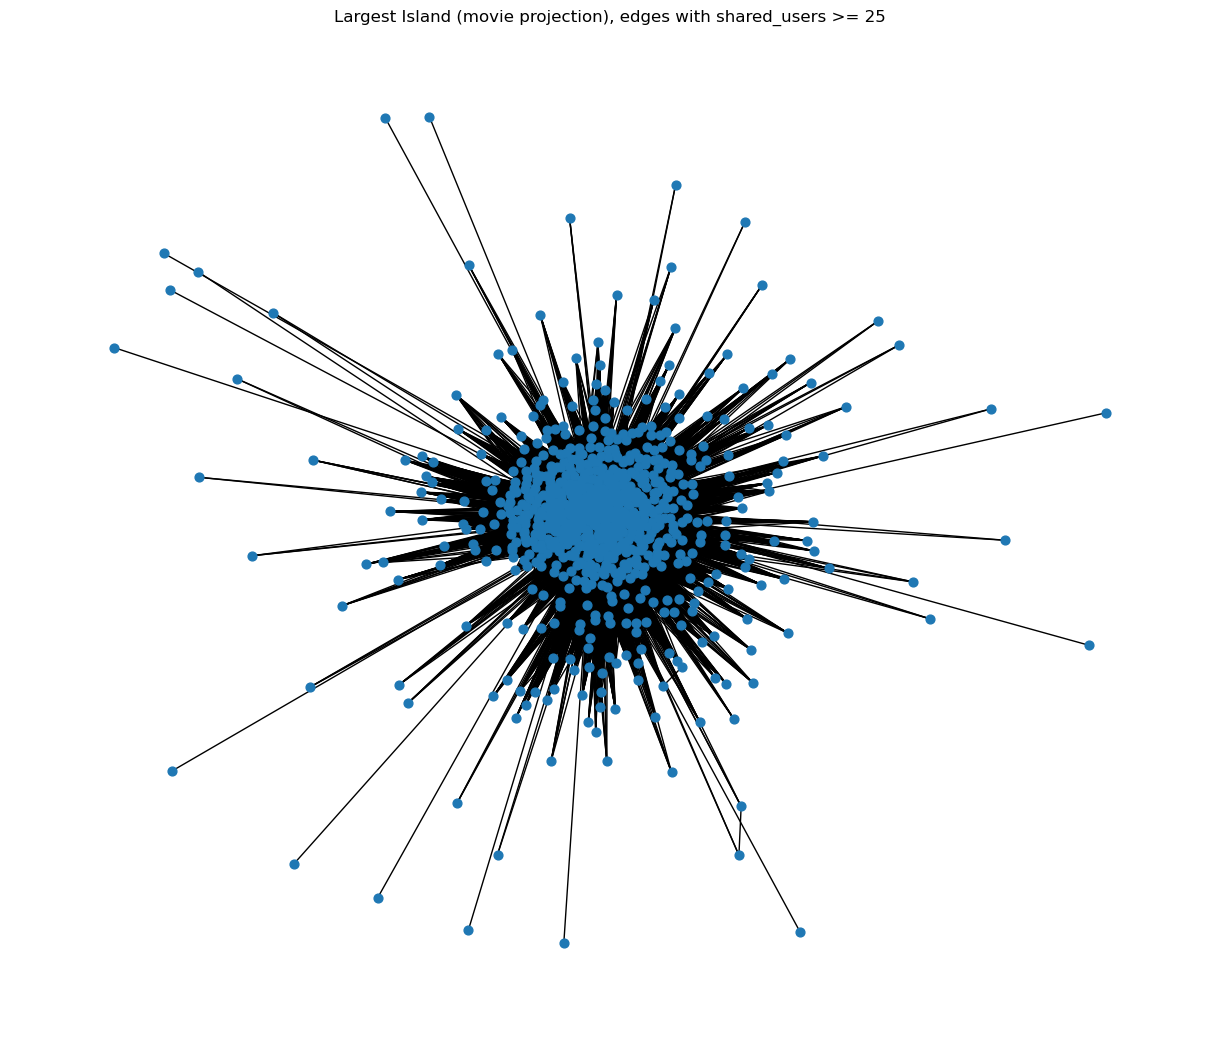

Drama        229
Comedy       213
Action       177
Crime         37
Adventure     36
Horror        27
Children      26
Animation     25
Mystery       14
Thriller      13
dtype: int64

In [14]:
# Grab the largest connected component (the biggest "island") if it exists
largest = components[0] if components else set()
H = G_islands.subgraph(largest).copy()

# Map node labels like "M50" back to the original numeric movie_id (50)
movie_id_map = {f"M{mid}": mid for mid in movies["movie_id"].values}

# Map movie_id -> genre (from the movies dataframe)
genre_map = dict(zip(movies["movie_id"], movies["genre"]))

# Build a node -> genre dictionary for the subgraph
H_genre = {}
for node in H.nodes():
    mid = movie_id_map.get(node, None)
    H_genre[node] = genre_map.get(mid, "unknown")

# Attach the genre label as a node attribute on the graph
nx.set_node_attributes(H, H_genre, "genre")

# Plot the largest island (basic view: no labels, small nodes)
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, seed=7, k=0.35)
nx.draw(H, pos, node_size=40, with_labels=False)
plt.title(f"Largest Island (movie projection), edges with shared_users >= {min_shared_users}")
plt.show()

# most common genres in this largest island
pd.Series(H_genre).value_counts().head(10)



# Clean Up the Largest Island Visualization (Make the Graph Easier to Read)
At this stage, the largest island is still too dense to interpret clearly, so this code reduces the clutter and makes the plot more readable. Instead of drawing every node in the component, it keeps only the top top_n movies based on weighted degree, meaning the movies that share the most users with other movies. It also attaches each node’s genre so we can summarize what kinds of movies dominate the cluster. To improve the visualization, edge thickness is scaled by the number of shared users (stronger links appear thicker), and only the top label_top_k nodes are labeled to avoid overlapping text. The final printout gives a quick snapshot of the reduced network size and density, plus the most common genres in the cleaned island.

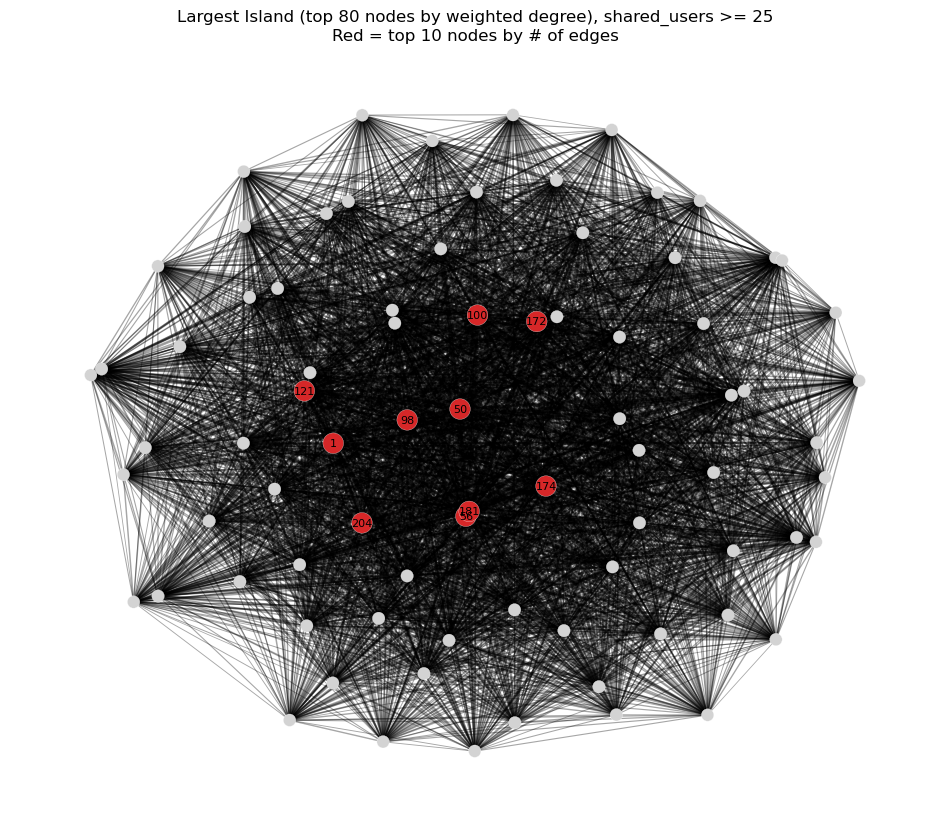

Nodes: 80 Edges: 3160 Density: 1.0


Action       33
Drama        16
Comedy       13
Crime         5
Adventure     4
Animation     3
Horror        2
Musical       1
Film-Noir     1
Sci-Fi        1
dtype: int64

In [15]:
# Keep the top N most-connected nodes (by weighted degree) so the plot stays readable
top_n = 80
label_top_k = 10          # how many of the most-connected nodes to label
highlight_top = 10        # how many of the most-connected nodes to highlight (color/size)

# Weighted degree = sum of edge weights connected to each node (here: total shared users across neighbors)
wdeg = dict(H.degree(weight="weight"))

# Select the top_n nodes by weighted degree and make a subgraph
keep_nodes = [n for n, _ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:top_n]]
H2 = H.subgraph(keep_nodes).copy()

# Attach each movie node's genre as a node attribute (for later summaries/plots)
H2_genre = {n: genre_map.get(movie_id_map.get(n), "unknown") for n in H2.nodes()}
nx.set_node_attributes(H2, H2_genre, "genre")

# Scale edge widths based on edge weight so stronger shared-audience links appear thicker
edge_w = np.array([d.get("weight", 1.0) for _, _, d in H2.edges(data=True)], dtype=float)
edge_width = 0.5 + 3.0 * (edge_w - edge_w.min()) / (edge_w.max() - edge_w.min() + 1e-9)

# Determine which nodes are the most connected (highest weighted degree) for highlighting + labeling
top_nodes = [n for n, _ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:highlight_top]]

# Create labels only for the top label_top_k nodes (to reduce clutter)
labels = {
    n: str(movie_id_map.get(n, n))
    for n, _ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:label_top_k]
}

# Color and size nodes: highlight the highest-degree nodes so they stand out visually
node_colors = ["tab:red" if n in top_nodes else "lightgray" for n in H2.nodes()]
node_sizes  = [220 if n in top_nodes else 80 for n in H2.nodes()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H2, seed=7, k=0.35)

# Draw edges first, then nodes, then labels
nx.draw_networkx_edges(H2, pos, width=edge_width, alpha=0.35)
nx.draw_networkx_nodes(H2, pos, node_size=node_sizes, node_color=node_colors, linewidths=0.2, edgecolors="white")
nx.draw_networkx_labels(H2, pos, labels=labels, font_size=8)

plt.title(f"Largest Island (top {top_n} nodes by weighted degree), shared_users >= {min_shared_users}\nRed = top {highlight_top} nodes by # of edges")
plt.axis("off")
plt.show()

# Summary stats + top genres in this filtered subgraph
print("Nodes:", H2.number_of_nodes(), "Edges:", H2.number_of_edges(), "Density:", nx.density(H2))
pd.Series(H2_genre).value_counts().head(10)


# Final Cleanup Attempt: Smaller Island View (Most Connected Movies Only)
Even after filtering by shared users, the largest island can still be hard to read because there are too many nodes and overlapping edges. This final version makes the visualization much cleaner by shrinking the graph to the top 40 movies with the highest weighted degree, which are the movies most strongly connected to others through shared user ratings. To keep the plot readable, it labels only the top 5 most connected nodes and scales edge thickness based on shared-user weight so stronger connections stand out without overwhelming the figure. The smaller figure size and slightly higher layout spacing (k=0.6) also help separate nodes. After plotting, the genre count summary provides quick context about what types of movies dominate this reduced core of the network.

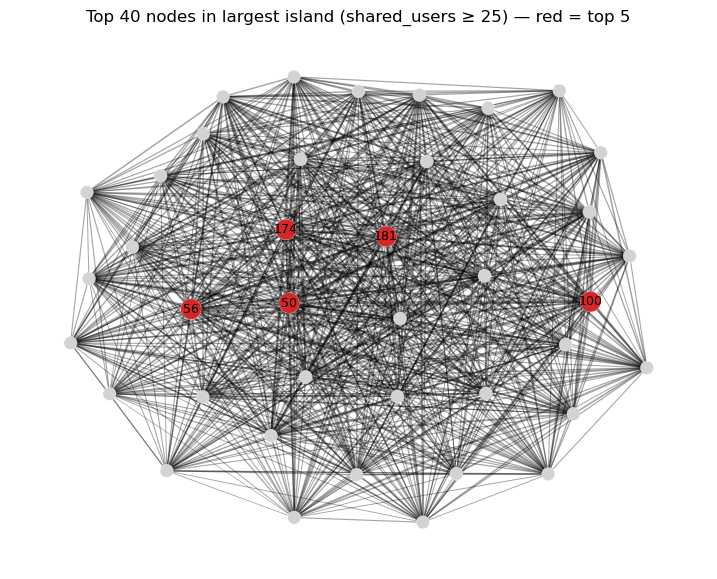

Action       20
Drama         7
Comedy        6
Crime         2
Children      1
Film-Noir     1
Animation     1
Adventure     1
dtype: int64

In [16]:
top_n = 40
label_top_k = 5
highlight_top = 5  # highlight the top nodes (by weighted degree)

wdeg = dict(H.degree(weight="weight"))
H2 = H.subgraph([n for n, _ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:top_n]]).copy()

H2_genre = {n: genre_map.get(movie_id_map.get(n), "unknown") for n in H2.nodes()}
nx.set_node_attributes(H2, H2_genre, "genre")

ew = np.array([d.get("weight", 1.0) for _, _, d in H2.edges(data=True)], float)
lw = 0.5 + 2.0 * (ew - ew.min()) / (ew.max() - ew.min() + 1e-9)

labels = {n: str(movie_id_map.get(n, n)) for n, _ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:label_top_k]}

# choose the top nodes and style them differently
top_nodes = [n for n, _ in sorted(wdeg.items(), key=lambda x: x[1], reverse=True)[:highlight_top]]
node_colors = ["tab:red" if n in top_nodes else "lightgray" for n in H2.nodes()]
node_sizes  = [220 if n in top_nodes else 90 for n in H2.nodes()]

plt.figure(figsize=(9, 7))
pos = nx.spring_layout(H2, seed=7, k=0.6)
nx.draw_networkx_edges(H2, pos, width=lw, alpha=0.35)
nx.draw_networkx_nodes(H2, pos, node_size=node_sizes, node_color=node_colors, linewidths=0.2, edgecolors="white")
nx.draw_networkx_labels(H2, pos, labels=labels, font_size=9)
plt.title(f"Top {top_n} nodes in largest island (shared_users ≥ {min_shared_users}) — red = top {highlight_top}")
plt.axis("off")
plt.show()

pd.Series(H2_genre).value_counts().head(8)


# What the Different Groups Mean
Each group in the network is a set of movies that share a lot of the same raters, so they end up connected to each other. A large, dense group usually means those movies are popular or have broad appeal, because many users rated them and created lots of overlaps. Inside each group, the movies with the most edges are the “hub” movies/titles that connect to many others because they are widely rated and often overlap across related tastes. Smaller groups, and especially movies with no edges, are often less rated or more niche, so there aren’t enough shared users (especially with your threshold) to link them strongly to other movies.

# Final Discussion and Conclusion
In this project, I used the MovieLens 100K dataset to build a two-mode network with two distinct groups: users and movies. After creating the bipartite graph, I projected it into a movie–movie network where movies connect when they share viewers. That projection quickly became too dense to read, so I used an island-style reduction by keeping only edges with a high number of shared users.
Even after that, the largest island was still cluttered, so I made the graph cleaner by keeping only the most connected movies (highest weighted degree) and labeling only a few key nodes. This final version made the structure easier to see and helped highlight the “core” movies that connect to many others. Looking at the genre counts in the reduced island also gave a simple way to describe what kinds of movies dominated that cluster.
Overall, the main takeaway is that network reduction matters. Filtering to stronger ties while focusing on the most connected nodes made the results more interpretable than trying to visualize the full network at once.